In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import _pickle as cPickle
import cPickle
import sys
sys.path.insert(0, '..')
import tensorflow as tf

#from helper import plot_mats

X = np.load('./shiftsuniform_x.npy').astype('float32')
Y = np.load('./shiftsuniform_y.npy').astype('float32')

numvisX = X.shape[1]
numvisY = Y.shape[1]
ntrain = X.shape[0]

def random_binomial(shape, p=0.0, dtype=None, seed=None):
    """Returns a tensor with random binomial distribution of values.
    # Arguments
        shape: A tuple of integers, the shape of tensor to create.
        p: A float, `0. <= p <= 1`, probability of binomial distribution.
        dtype: String, dtype of returned tensor.
        seed: Integer, random seed.
    # Returns
        A tensor.
    """
    if dtype is None:
        dtype = 'float32'
    if seed is None:
        seed = np.random.randint(10e6)
    return tf.where(tf.random_uniform(shape, dtype=dtype, seed=seed) <= p,
                    tf.ones(shape, dtype=dtype),
                    tf.zeros(shape, dtype=dtype))

def dispims(M, height, width, border=0, bordercolor=0.0, layout=None, **kwargs):
    from pylab import cm, ceil
    numimages = M.shape[1]
    if layout is None:
        n0 = int(np.ceil(np.sqrt(numimages)))
        n1 = int(np.ceil(np.sqrt(numimages)))
    else:
        n0, n1 = layout
    im = bordercolor * np.ones(((height+border)*n0+border,(width+border)*n1+border),dtype='<f8')
    for i in range(n0):
        for j in range(n1):
            if i*n1+j < M.shape[1]:
                im[i*(height+border)+border:(i+1)*(height+border)+border,
                   j*(width+border)+border :(j+1)*(width+border)+border] = np.vstack((
                            np.hstack((np.reshape(M[:,i*n1+j],(height, width)),
                                   bordercolor*np.ones((height,border),dtype=float))),
                            bordercolor*np.ones((border,width+border),dtype=float)
                            ))
    pylab.imshow(im, cmap=cm.gray, interpolation='nearest', **kwargs)
    pylab.show()

    
    

numpy_rng = np.random.RandomState(1)

numfac  = 100
nummap  = 25

#NORMALIZE DATA:
X -= X.mean(0)[None, :]
Y -= Y.mean(0)[None, :]
X /= X.std(0)[None, :] + X.std() * 0.1
Y /= Y.std(0)[None, :] + Y.std() * 0.1


inputsX = tf.placeholder(tf.float32, [None, numvisX])
inputsY = tf.placeholder(tf.float32, [None, numvisY])

wxf = tf.Variable(tf.random_normal(shape=(numvisX, numfac)) * 0.01)
wyf = tf.Variable(tf.random_normal(shape=(numvisY, numfac)) * 0.01)

whf = tf.Variable(np.exp(numpy_rng.uniform(low=-3.0, high=-2.0, size=(nummap, numfac)),dtype='float32'))
whf_in = tf.Variable(numpy_rng.uniform(low=-0.01, high=+0.01, size=(nummap, numfac)).astype('float32'))

bmap = tf.Variable(np.zeros(nummap, dtype='float32'), name='bmap')
bvisX = tf.Variable(np.zeros(numvisX, dtype='float32'), name='bvisX')
bvisY = tf.Variable(np.zeros(numvisY, dtype='float32'), name='bvisY')


CorruptedX = tf.multiply(random_binomial(tf.shape(inputsX),p=0.5),inputsX)
CorruptedY = tf.multiply(random_binomial(tf.shape(inputsY),p=0.5),inputsY)

fx = tf.matmul(CorruptedX , wxf)
fy = tf.matmul(CorruptedY , wyf)

mappings = tf.sigmoid(tf.matmul(tf.multiply(fx , fy), tf.transpose(whf_in))+ bmap)
fH = tf.matmul(mappings, whf)

outputx = tf.matmul(tf.multiply(fy , fH),tf.transpose(wxf)) + bvisX
outputy = tf.matmul(tf.multiply(fx , fH),tf.transpose(wyf)) + bvisY
#output = tf.matmul(fH,tf.transpose(wxf))

cost = tf.nn.l2_loss(outputx-inputsX) + tf.nn.l2_loss(outputy-inputsY)

#+tf.reduce_sum(wxf**2)

optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)




        

In [2]:
def normalizefilters(sess,_wxf,_wyf,center=True):
        def inplacemult(x, v):
            x[:, :] *= v
            return x
        def inplacesubtract(x, v):
            x[:, :] -= v
            return x
        wxf_ = _wxf.eval(sess)
        wyf_ = _wyf.eval(sess)
        nwxf = (wxf_.std(0)+SMALL)[np.newaxis, :]
        nwyf = (wyf_.std(0)+SMALL)[np.newaxis, :]
        meannxf = nwxf.mean()
        meannyf = nwyf.mean()

        # CENTER FILTERS 
        if center:
            _wxf.assign(inplacesubtract(wxf_, wxf_.mean(0)[np.newaxis,:])).eval()
            _wyf.assign(inplacesubtract(wyf_, wyf_.mean(0)[np.newaxis,:])).eval()
        # FIX STANDARD DEVIATION 
        _wxf.assign(inplacemult(wxf_, meannxf/nwxf)).eval()
        _wyf.assign(inplacemult(wyf_, meannyf/nwyf)).eval()

Epoch: 000/3000 cost: 139.726675000
Epoch: 001/3000 cost: 139.809425000
Epoch: 002/3000 cost: 139.927200000
Epoch: 003/3000 cost: 140.069025000
Epoch: 004/3000 cost: 140.190450000
Epoch: 005/3000 cost: 140.257650000
Epoch: 006/3000 cost: 140.287487500
Epoch: 007/3000 cost: 140.242975000
Epoch: 008/3000 cost: 140.152400000
Epoch: 009/3000 cost: 140.052825000
Epoch: 010/3000 cost: 139.970975000
Epoch: 011/3000 cost: 139.882487500
Epoch: 012/3000 cost: 139.831900000
Epoch: 013/3000 cost: 139.814875000
Epoch: 014/3000 cost: 139.849887500
Epoch: 015/3000 cost: 139.890100000
Epoch: 016/3000 cost: 139.917762500
Epoch: 017/3000 cost: 139.919400000
Epoch: 018/3000 cost: 139.904400000
Epoch: 019/3000 cost: 139.859375000
Epoch: 020/3000 cost: 139.811525000
Epoch: 021/3000 cost: 139.748950000
Epoch: 022/3000 cost: 139.702700000
Epoch: 023/3000 cost: 139.667625000
Epoch: 024/3000 cost: 139.640262500
Epoch: 025/3000 cost: 139.636200000
Epoch: 026/3000 cost: 139.653125000
Epoch: 027/3000 cost: 139.65

Epoch: 228/3000 cost: 132.485700000
Epoch: 229/3000 cost: 132.550300000
Epoch: 230/3000 cost: 132.544150000
Epoch: 231/3000 cost: 132.422700000
Epoch: 232/3000 cost: 132.415787500
Epoch: 233/3000 cost: 132.439525000
Epoch: 234/3000 cost: 132.490275000
Epoch: 235/3000 cost: 132.477662500
Epoch: 236/3000 cost: 132.465550000
Epoch: 237/3000 cost: 132.394800000
Epoch: 238/3000 cost: 132.341650000
Epoch: 239/3000 cost: 132.299412500
Epoch: 240/3000 cost: 132.355937500
Epoch: 241/3000 cost: 132.358200000
Epoch: 242/3000 cost: 132.370637500
Epoch: 243/3000 cost: 132.328850000
Epoch: 244/3000 cost: 132.267950000
Epoch: 245/3000 cost: 132.235525000
Epoch: 246/3000 cost: 132.271675000
Epoch: 247/3000 cost: 132.275537500
Epoch: 248/3000 cost: 132.326812500
Epoch: 249/3000 cost: 132.366900000
Epoch: 250/3000 cost: 132.308762500
Epoch: 251/3000 cost: 132.320912500
Epoch: 252/3000 cost: 132.225150000
Epoch: 253/3000 cost: 132.270412500
Epoch: 254/3000 cost: 132.235375000
Epoch: 255/3000 cost: 132.30

Epoch: 456/3000 cost: 131.720275000
Epoch: 457/3000 cost: 131.705225000
Epoch: 458/3000 cost: 131.696175000
Epoch: 459/3000 cost: 131.775175000
Epoch: 460/3000 cost: 131.731862500
Epoch: 461/3000 cost: 131.694800000
Epoch: 462/3000 cost: 131.692162500
Epoch: 463/3000 cost: 131.739712500
Epoch: 464/3000 cost: 131.783525000
Epoch: 465/3000 cost: 131.768825000
Epoch: 466/3000 cost: 131.722462500
Epoch: 467/3000 cost: 131.739300000
Epoch: 468/3000 cost: 131.783562500
Epoch: 469/3000 cost: 131.770850000
Epoch: 470/3000 cost: 131.789625000
Epoch: 471/3000 cost: 131.740100000
Epoch: 472/3000 cost: 131.702000000
Epoch: 473/3000 cost: 131.657025000
Epoch: 474/3000 cost: 131.694875000
Epoch: 475/3000 cost: 131.736512500
Epoch: 476/3000 cost: 131.770750000
Epoch: 477/3000 cost: 131.749775000
Epoch: 478/3000 cost: 131.686575000
Epoch: 479/3000 cost: 131.644950000
Epoch: 480/3000 cost: 131.633475000
Epoch: 481/3000 cost: 131.698775000
Epoch: 482/3000 cost: 131.703000000
Epoch: 483/3000 cost: 131.70

Epoch: 684/3000 cost: 131.411775000
Epoch: 685/3000 cost: 131.481450000
Epoch: 686/3000 cost: 131.542475000
Epoch: 687/3000 cost: 131.525600000
Epoch: 688/3000 cost: 131.488725000
Epoch: 689/3000 cost: 131.437562500
Epoch: 690/3000 cost: 131.398525000
Epoch: 691/3000 cost: 131.362125000
Epoch: 692/3000 cost: 131.412662500
Epoch: 693/3000 cost: 131.390875000
Epoch: 694/3000 cost: 131.323450000
Epoch: 695/3000 cost: 131.301775000
Epoch: 696/3000 cost: 131.310025000
Epoch: 697/3000 cost: 131.267112500
Epoch: 698/3000 cost: 131.345125000
Epoch: 699/3000 cost: 131.337200000
Epoch: 700/3000 cost: 131.296812500
Epoch: 701/3000 cost: 131.374675000
Epoch: 702/3000 cost: 131.390575000
Epoch: 703/3000 cost: 131.343325000
Epoch: 704/3000 cost: 131.267425000
Epoch: 705/3000 cost: 131.227687500
Epoch: 706/3000 cost: 131.289937500
Epoch: 707/3000 cost: 131.274075000
Epoch: 708/3000 cost: 131.387200000
Epoch: 709/3000 cost: 131.406050000
Epoch: 710/3000 cost: 131.293875000
Epoch: 711/3000 cost: 131.26

Epoch: 912/3000 cost: 131.067575000
Epoch: 913/3000 cost: 131.099337500
Epoch: 914/3000 cost: 131.177375000
Epoch: 915/3000 cost: 131.205400000
Epoch: 916/3000 cost: 131.119775000
Epoch: 917/3000 cost: 131.065062500
Epoch: 918/3000 cost: 130.968875000
Epoch: 919/3000 cost: 130.970375000
Epoch: 920/3000 cost: 130.975975000
Epoch: 921/3000 cost: 131.038112500
Epoch: 922/3000 cost: 131.103525000
Epoch: 923/3000 cost: 131.116850000
Epoch: 924/3000 cost: 131.024950000
Epoch: 925/3000 cost: 131.021912500
Epoch: 926/3000 cost: 130.979925000
Epoch: 927/3000 cost: 131.065750000
Epoch: 928/3000 cost: 131.017625000
Epoch: 929/3000 cost: 131.026037500
Epoch: 930/3000 cost: 130.971625000
Epoch: 931/3000 cost: 130.942525000
Epoch: 932/3000 cost: 130.989200000
Epoch: 933/3000 cost: 131.028800000
Epoch: 934/3000 cost: 131.110850000
Epoch: 935/3000 cost: 131.149350000
Epoch: 936/3000 cost: 131.079450000
Epoch: 937/3000 cost: 131.017725000
Epoch: 938/3000 cost: 130.959900000
Epoch: 939/3000 cost: 130.93

Epoch: 1136/3000 cost: 130.733175000
Epoch: 1137/3000 cost: 130.719437500
Epoch: 1138/3000 cost: 130.705300000
Epoch: 1139/3000 cost: 130.812287500
Epoch: 1140/3000 cost: 130.873450000
Epoch: 1141/3000 cost: 130.906162500
Epoch: 1142/3000 cost: 130.895787500
Epoch: 1143/3000 cost: 130.818837500
Epoch: 1144/3000 cost: 130.742300000
Epoch: 1145/3000 cost: 130.676712500
Epoch: 1146/3000 cost: 130.700675000
Epoch: 1147/3000 cost: 130.722700000
Epoch: 1148/3000 cost: 130.840200000
Epoch: 1149/3000 cost: 130.981275000
Epoch: 1150/3000 cost: 130.973987500
Epoch: 1151/3000 cost: 130.865237500
Epoch: 1152/3000 cost: 130.759375000
Epoch: 1153/3000 cost: 130.696200000
Epoch: 1154/3000 cost: 130.697237500
Epoch: 1155/3000 cost: 130.701400000
Epoch: 1156/3000 cost: 130.761012500
Epoch: 1157/3000 cost: 130.749325000
Epoch: 1158/3000 cost: 130.790675000
Epoch: 1159/3000 cost: 130.761337500
Epoch: 1160/3000 cost: 130.796075000
Epoch: 1161/3000 cost: 130.776925000
Epoch: 1162/3000 cost: 130.844325000
E

Epoch: 1358/3000 cost: 130.647912500
Epoch: 1359/3000 cost: 130.667550000
Epoch: 1360/3000 cost: 130.625262500
Epoch: 1361/3000 cost: 130.593250000
Epoch: 1362/3000 cost: 130.554687500
Epoch: 1363/3000 cost: 130.525200000
Epoch: 1364/3000 cost: 130.528187500
Epoch: 1365/3000 cost: 130.596025000
Epoch: 1366/3000 cost: 130.567275000
Epoch: 1367/3000 cost: 130.550837500
Epoch: 1368/3000 cost: 130.567150000
Epoch: 1369/3000 cost: 130.493225000
Epoch: 1370/3000 cost: 130.525350000
Epoch: 1371/3000 cost: 130.516825000
Epoch: 1372/3000 cost: 130.536975000
Epoch: 1373/3000 cost: 130.562550000
Epoch: 1374/3000 cost: 130.548875000
Epoch: 1375/3000 cost: 130.558850000
Epoch: 1376/3000 cost: 130.557862500
Epoch: 1377/3000 cost: 130.601762500
Epoch: 1378/3000 cost: 130.630225000
Epoch: 1379/3000 cost: 130.686212500
Epoch: 1380/3000 cost: 130.656900000
Epoch: 1381/3000 cost: 130.626175000
Epoch: 1382/3000 cost: 130.591225000
Epoch: 1383/3000 cost: 130.634937500
Epoch: 1384/3000 cost: 130.589475000
E

Epoch: 1580/3000 cost: 130.369675000
Epoch: 1581/3000 cost: 130.366250000
Epoch: 1582/3000 cost: 130.343400000
Epoch: 1583/3000 cost: 130.335550000
Epoch: 1584/3000 cost: 130.353225000
Epoch: 1585/3000 cost: 130.328500000
Epoch: 1586/3000 cost: 130.329275000
Epoch: 1587/3000 cost: 130.345700000
Epoch: 1588/3000 cost: 130.375025000
Epoch: 1589/3000 cost: 130.295200000
Epoch: 1590/3000 cost: 130.323625000
Epoch: 1591/3000 cost: 130.243212500
Epoch: 1592/3000 cost: 130.212500000
Epoch: 1593/3000 cost: 130.255700000
Epoch: 1594/3000 cost: 130.358425000
Epoch: 1595/3000 cost: 130.401550000
Epoch: 1596/3000 cost: 130.390650000
Epoch: 1597/3000 cost: 130.276100000
Epoch: 1598/3000 cost: 130.249375000
Epoch: 1599/3000 cost: 130.303212500
Epoch: 1600/3000 cost: 130.363850000
Epoch: 1601/3000 cost: 130.357850000
Epoch: 1602/3000 cost: 130.333175000
Epoch: 1603/3000 cost: 130.349712500
Epoch: 1604/3000 cost: 130.212312500
Epoch: 1605/3000 cost: 130.230775000
Epoch: 1606/3000 cost: 130.255000000
E

Epoch: 1802/3000 cost: 130.092962500
Epoch: 1803/3000 cost: 129.993575000
Epoch: 1804/3000 cost: 129.974100000
Epoch: 1805/3000 cost: 129.959225000
Epoch: 1806/3000 cost: 129.955225000
Epoch: 1807/3000 cost: 129.888775000
Epoch: 1808/3000 cost: 129.935400000
Epoch: 1809/3000 cost: 129.983950000
Epoch: 1810/3000 cost: 130.063475000
Epoch: 1811/3000 cost: 130.000737500
Epoch: 1812/3000 cost: 129.981987500
Epoch: 1813/3000 cost: 129.983400000
Epoch: 1814/3000 cost: 129.990650000
Epoch: 1815/3000 cost: 129.938000000
Epoch: 1816/3000 cost: 129.903725000
Epoch: 1817/3000 cost: 129.930000000
Epoch: 1818/3000 cost: 130.003950000
Epoch: 1819/3000 cost: 130.035912500
Epoch: 1820/3000 cost: 130.051700000
Epoch: 1821/3000 cost: 130.043125000
Epoch: 1822/3000 cost: 130.076862500
Epoch: 1823/3000 cost: 130.084025000
Epoch: 1824/3000 cost: 130.154200000
Epoch: 1825/3000 cost: 130.117550000
Epoch: 1826/3000 cost: 130.108875000
Epoch: 1827/3000 cost: 130.111600000
Epoch: 1828/3000 cost: 130.074887500
E

Epoch: 2024/3000 cost: 129.882862500
Epoch: 2025/3000 cost: 129.965575000
Epoch: 2026/3000 cost: 129.920850000
Epoch: 2027/3000 cost: 129.789300000
Epoch: 2028/3000 cost: 129.701675000
Epoch: 2029/3000 cost: 129.755362500
Epoch: 2030/3000 cost: 129.799875000
Epoch: 2031/3000 cost: 129.981950000
Epoch: 2032/3000 cost: 129.942550000
Epoch: 2033/3000 cost: 129.874625000
Epoch: 2034/3000 cost: 129.798550000
Epoch: 2035/3000 cost: 129.760225000
Epoch: 2036/3000 cost: 129.783587500
Epoch: 2037/3000 cost: 129.853162500
Epoch: 2038/3000 cost: 129.830200000
Epoch: 2039/3000 cost: 129.826500000
Epoch: 2040/3000 cost: 129.754700000
Epoch: 2041/3000 cost: 129.722875000
Epoch: 2042/3000 cost: 129.714525000
Epoch: 2043/3000 cost: 129.758150000
Epoch: 2044/3000 cost: 129.766100000
Epoch: 2045/3000 cost: 129.785537500
Epoch: 2046/3000 cost: 129.768825000
Epoch: 2047/3000 cost: 129.712875000
Epoch: 2048/3000 cost: 129.711150000
Epoch: 2049/3000 cost: 129.741062500
Epoch: 2050/3000 cost: 129.803425000
E

Epoch: 2246/3000 cost: 129.472750000
Epoch: 2247/3000 cost: 129.551675000
Epoch: 2248/3000 cost: 129.542887500
Epoch: 2249/3000 cost: 129.580575000
Epoch: 2250/3000 cost: 129.613400000
Epoch: 2251/3000 cost: 129.588575000
Epoch: 2252/3000 cost: 129.590025000
Epoch: 2253/3000 cost: 129.603975000
Epoch: 2254/3000 cost: 129.609025000
Epoch: 2255/3000 cost: 129.633875000
Epoch: 2256/3000 cost: 129.565112500
Epoch: 2257/3000 cost: 129.526100000
Epoch: 2258/3000 cost: 129.452600000
Epoch: 2259/3000 cost: 129.549500000
Epoch: 2260/3000 cost: 129.642025000
Epoch: 2261/3000 cost: 129.619875000
Epoch: 2262/3000 cost: 129.629337500
Epoch: 2263/3000 cost: 129.597675000
Epoch: 2264/3000 cost: 129.515500000
Epoch: 2265/3000 cost: 129.536337500
Epoch: 2266/3000 cost: 129.568600000
Epoch: 2267/3000 cost: 129.479725000
Epoch: 2268/3000 cost: 129.521625000
Epoch: 2269/3000 cost: 129.520487500
Epoch: 2270/3000 cost: 129.616062500
Epoch: 2271/3000 cost: 129.674712500
Epoch: 2272/3000 cost: 129.559975000
E

Epoch: 2468/3000 cost: 129.344462500
Epoch: 2469/3000 cost: 129.301025000
Epoch: 2470/3000 cost: 129.301275000
Epoch: 2471/3000 cost: 129.289750000
Epoch: 2472/3000 cost: 129.275025000
Epoch: 2473/3000 cost: 129.231700000
Epoch: 2474/3000 cost: 129.271100000
Epoch: 2475/3000 cost: 129.256562500
Epoch: 2476/3000 cost: 129.314975000
Epoch: 2477/3000 cost: 129.342575000
Epoch: 2478/3000 cost: 129.313575000
Epoch: 2479/3000 cost: 129.223437500
Epoch: 2480/3000 cost: 129.257250000
Epoch: 2481/3000 cost: 129.351375000
Epoch: 2482/3000 cost: 129.453075000
Epoch: 2483/3000 cost: 129.431637500
Epoch: 2484/3000 cost: 129.327150000
Epoch: 2485/3000 cost: 129.265650000
Epoch: 2486/3000 cost: 129.215712500
Epoch: 2487/3000 cost: 129.275937500
Epoch: 2488/3000 cost: 129.372275000
Epoch: 2489/3000 cost: 129.332950000
Epoch: 2490/3000 cost: 129.286450000
Epoch: 2491/3000 cost: 129.198925000
Epoch: 2492/3000 cost: 129.218800000
Epoch: 2493/3000 cost: 129.226600000
Epoch: 2494/3000 cost: 129.284137500
E

Epoch: 2690/3000 cost: 128.926675000
Epoch: 2691/3000 cost: 129.068800000
Epoch: 2692/3000 cost: 129.147750000
Epoch: 2693/3000 cost: 129.179525000
Epoch: 2694/3000 cost: 129.129037500
Epoch: 2695/3000 cost: 129.027950000
Epoch: 2696/3000 cost: 128.922112500
Epoch: 2697/3000 cost: 128.912800000
Epoch: 2698/3000 cost: 129.012425000
Epoch: 2699/3000 cost: 129.117837500
Epoch: 2700/3000 cost: 129.136112500
Epoch: 2701/3000 cost: 129.078175000
Epoch: 2702/3000 cost: 129.012075000
Epoch: 2703/3000 cost: 128.950550000
Epoch: 2704/3000 cost: 128.890200000
Epoch: 2705/3000 cost: 129.078875000
Epoch: 2706/3000 cost: 129.186450000
Epoch: 2707/3000 cost: 129.170300000
Epoch: 2708/3000 cost: 129.092537500
Epoch: 2709/3000 cost: 129.046675000
Epoch: 2710/3000 cost: 128.886675000
Epoch: 2711/3000 cost: 128.959300000
Epoch: 2712/3000 cost: 129.037887500
Epoch: 2713/3000 cost: 129.129425000
Epoch: 2714/3000 cost: 129.084150000
Epoch: 2715/3000 cost: 128.976150000
Epoch: 2716/3000 cost: 128.922687500
E

Epoch: 2912/3000 cost: 128.896425000
Epoch: 2913/3000 cost: 129.008587500
Epoch: 2914/3000 cost: 129.009150000
Epoch: 2915/3000 cost: 129.136975000
Epoch: 2916/3000 cost: 129.155662500
Epoch: 2917/3000 cost: 129.104825000
Epoch: 2918/3000 cost: 129.001050000
Epoch: 2919/3000 cost: 128.917500000
Epoch: 2920/3000 cost: 128.952937500
Epoch: 2921/3000 cost: 128.950300000
Epoch: 2922/3000 cost: 128.990837500
Epoch: 2923/3000 cost: 129.017062500
Epoch: 2924/3000 cost: 128.909300000
Epoch: 2925/3000 cost: 128.864400000
Epoch: 2926/3000 cost: 128.964100000
Epoch: 2927/3000 cost: 128.934512500
Epoch: 2928/3000 cost: 128.928562500
Epoch: 2929/3000 cost: 128.890425000
Epoch: 2930/3000 cost: 128.812037500
Epoch: 2931/3000 cost: 128.738787500
Epoch: 2932/3000 cost: 128.701775000
Epoch: 2933/3000 cost: 128.707750000
Epoch: 2934/3000 cost: 128.800800000
Epoch: 2935/3000 cost: 128.829750000
Epoch: 2936/3000 cost: 128.836500000
Epoch: 2937/3000 cost: 128.769387500
Epoch: 2938/3000 cost: 128.747550000
E

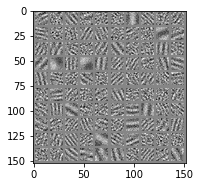

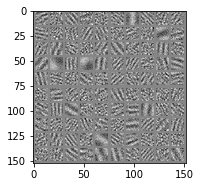

In [3]:


training_epochs = 3000
batch_size = 100
SMALL = 0.000001


with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(training_epochs):
        randidx  = np.random.randint(ntrain, size=batch_size).astype('int32')
        batch_xs = X[randidx]
        batch_ys = Y[randidx]  
        sess.run(optimizer, feed_dict={inputsX: batch_xs, inputsY: batch_ys})
        
        normalizefilters(sess,wxf,wyf)
        
        cost_ = sess.run(cost, feed_dict={inputsX: X, inputsY: Y}) / ntrain
        print ("Epoch: %03d/%03d cost: %.9f" % (epoch,training_epochs ,cost_) ) 

    import pylab
    pylab.subplot(1, 2, 1)
    dispims(wxf.eval(sess), 13, 13, 2)
    pylab.subplot(1, 2, 2)
    dispims(wyf.eval(sess), 13, 13, 2)